In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import quspin
from quspin.operators import hamiltonian
from quspin.basis import spin_basis_1d # Hilbert space spin basis

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
import numpy.random as rn

import qiskit
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.visualization import plot_histogram

from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.circuit.random import random_circuit

import time
start = time.time()
 
L_time=[]
L_count=[]
FIGSIZE = (21, 10) #: Figure size, in inches!
mpl.rcParams['figure.figsize'] = FIGSIZE

# Use Aer's qasm_simulator
dev = Aer.get_backend('qasm_simulator')

L=8
Lin = 3
Lout = 2

l = 2**L
m = 2**Lin    
    
# Create a Quantum Circuit acting on the q register
qc_init = QuantumCircuit(L, L)
qc_had = QuantumCircuit(L, L)

qc_rot = QuantumCircuit(L,L)
qc_ent = QuantumCircuit(L,L)
qc_out = QuantumCircuit(L,L)
qc_fix = QuantumCircuit(L,L)

qc_had.h(0)
qc_had.h(1)
qc_had.h(2)
qc_had.h(3)
qc_had.h(4)
qc_had.h(5)
qc_had.h(6)
qc_had.h(7)

qc_ent.cx(0,1)
qc_ent.cx(1,2)
qc_ent.cx(2,3)
qc_ent.cx(3,4)
qc_ent.cx(4,5)
qc_ent.cx(5,6)
qc_ent.cx(6,7)
qc_ent.cx(7,0)

qc_out.measure(5,5)
qc_out.measure(6,6)
qc_out.measure(7,7)

# Fix the first 3 qubits to simulate an external magnetic field
qc_fix.measure(0,0)
qc_fix.measure(1,1)
qc_fix.measure(2,2)

##### set up Heisenberg Hamiltonian in an external z-field #####
# compute spin-1/2 basis
basis = spin_basis_1d(L,pauli=False)
x=[]
target=[]
#iterates through spin configurations and converts
#each number to its binary representation

def unpackbits(x,num_bits):
    xshape = list(x.shape)
    x = x.reshape([-1,1])
    to_and = 2**np.arange(num_bits).reshape([1,num_bits])
    return (x & to_and).astype(bool).astype(int).reshape(xshape + [num_bits])

for i in range(0,l):
    X = np.array([i], dtype=np.uint16)
    X_bits = unpackbits(X, 16)
    Y=np.array(X_bits).tolist()
    for j in range(len(Y)):
        x.append(Y[j])    
    
qc_list = []    
    
#iterates through spin configurations and adds up all the bits
for i in range(0,m):
    bitcount = 0
    for j in range(0, L):
        if x[i][j] == 1:
            bitcount = bitcount + 1
    target.append(i)
    target[i] = bitcount    

    
    qc_enc = QuantumCircuit(L, L)
    #Encodes bit string as initial states of qubits    
    for n, j in enumerate(x[i]):
            if j == 1:
                qc_enc.x(n)

    qc_init = qc_enc + qc_fix 
    qc_list.insert(i, qc_init)

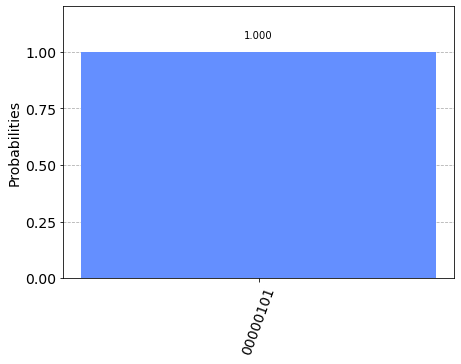

In [2]:
    counts = execute(qc_list[5], dev).result().get_counts()
    plot_histogram(counts)
    #print(counts)

In [3]:
    qc_sum = qc_list[0] + qc_list[1] + qc_list[2] + qc_list[3] + qc_list[4] + qc_list[5] +  qc_list[6] + qc_list[7] 
    #qc_sum.draw()

In [4]:
    def annealing(cost_function, acceptance, temperature, maxsteps=1000, debug=True):
        """ Optimize the black-box function 'cost_function' with the
        simulated annealing algorithm."""
        J = [[rn.random(),i,j] for i in range(0, L-1) for j in range(i+1, L)]

        cost = cost_function(J)
        states, costs = [J], [cost]
        for step in range(maxsteps):
            fraction = step / float(maxsteps)
            T = temperature(fraction)
            new_J=[]
            for i in range(len(J)):
                new_J.append([J[i][0]+0.5*np.random.randn(),J[i][1],J[i][2]])
                new_cost = cost_function(new_J)
            if debug: print("Step #{:>2}/{:>2} : T = {:>4.3g}, cost = {:>4.8g}, \n\t\t new_cost = {:>4.8g} ...\n".format(step, maxsteps, T, cost, new_cost))
            if acceptance_probability(cost, new_cost, T) > rn.random():
                J, cost = new_J, new_cost
  
                qc_rot.ry(J[0][0],3)
                qc_rot.rz(J[0][0],3)
                qc_rot.ry(J[0][0],4)
                qc_rot.rz(J[0][0],4)
                qc_rot.ry(J[0][0],5)
                qc_rot.rz(J[0][0],5)
                qc_rot.ry(J[0][0],6)
                qc_rot.rz(J[0][0],6)
                qc_rot.ry(J[0][0],7)
                qc_rot.rz(J[0][0],7)

                states.append(J)
                costs.append(cost)
        return J, cost_function(J), states, costs


In [5]:
    def acceptance_probability(cost, new_cost, temperature):
        if new_cost < cost:
            return 1
        else:
            p = np.exp(- (new_cost - cost) / temperature)
            return p
        return

    def temperature(fraction):
        """ Example of temperature decreasing as the process goes on."""
        return max(0.01, 100*min(1, (1 - fraction)))

In [6]:
    def cost_function(J):
        accumulated_error = 0.0
        pred = []
        for i in range(0,m):
            hz = [[10*(2*x[i][j]-1),j] for j in range(Lin)]
            static = [["+-",J],["-+",J],["zz",J],["z",hz]]
            dynamic = []
            H_XXZ = hamiltonian(static,dynamic,basis=basis,dtype=np.float64)
            # calculate full eigensystem
            Eigvalues,V = H_XXZ.eigh()

            SZ = [0 for jj in range(Lout)]
            for n in range(0, 2**L):
                weight = V[0][n]*V[0][n]
                for ii in range(L-Lout, L):
                    test = n & (2**ii)
                    if test:
                        SZ[ii-(L-Lout)]+=weight
                    else:
                        SZ[ii-(L-Lout)]-=weight

            prediction=0
            for k in range(Lout):
                if SZ[k] > 0:
                    prediction += 2**k

            print(target[i], prediction)
            accumulated_error += (prediction - target[i])**2

            if accumulated_error == 0:
                pred.append(prediction)

                f= open("pred_bitcount.txt","w+")

                for i in range(len(pred)):
                    f.write(str(pred[i]))
                    f.write('\n')

                f.close()

        return accumulated_error

In [7]:
    J, cost, states, costs = annealing(cost_function, acceptance_probability, temperature, maxsteps=30, debug=True)

    predicted_bitcount = open('pred_bitcount.txt', 'r')
    pr_bit = predicted_bitcount.read()
    pr_bit=pr_bit.replace(" ", ",")
    pr_bit=pr_bit.split("\n")

    pred_bit = []

    for index in range(0, len(pr_bit)-1):
        pred_bit.append(int(pr_bit[index]))

    end = time.time()

    time = end - start

Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Sy

Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Sy

2 3
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed

Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Sy

3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed

1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed

2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed

1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed

Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Sy

2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed

1 2
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 2
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 2
Hermiticity check passed!
Symmetry checks passed!
1 2
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 2
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 2
Hermiticity check passed!
Symmetry checks passed!
1 2
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 2
Hermiticity check passed

0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed

1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed

Symmetry checks passed!
3 3
Step # 8/30 : T = 73.3, cost =    6, 
		 new_cost =    6 ...

Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 0
Hermiticity check passed!
Symmetry checks passed!
1 0
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 0
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks pass

3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 2
Hermiticity check passed!
Symmetry checks passed!
1 2
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 2
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 2
Hermiticity check passed

Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Sy

2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed

3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 2
Hermiticity check passed!
Symmetry checks passed!
1 2
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 2
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 2
Hermiticity check passed

Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Sy

Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Sy

1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 2
Hermiticity check passed!
Symmetry checks passed!
1 2
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 2
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed

2 2
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed

1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed

1 2
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed

0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed

Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Sy

2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Step #17/30 : T = 43.3, cost =    2, 
		 new_cost =    0 ...

Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity chec

0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed

0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed

1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed

0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed

2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed

Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1


2 3
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed

3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed

Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Sy

Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Step #24/30 : T =   20, cost =    0, 
		 new_cost =    0 ...

Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check pa

1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed

1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed

Hermiticity check passed!
Symmetry checks passed!
3 3
Step #26/30 : T = 13.3, cost =    0, 
		 new_cost =    0 ...

Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check pa

0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 3
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed

1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed

2 2
Hermiticity check passed!
Symmetry checks passed!
1 0
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 0
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 0
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed

Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Symmetry checks passed!
3 3
Hermiticity check passed!
Symmetry checks passed!
0 0
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
1 1
Hermiticity check passed!
Symmetry checks passed!
2 2
Hermiticity check passed!
Sy

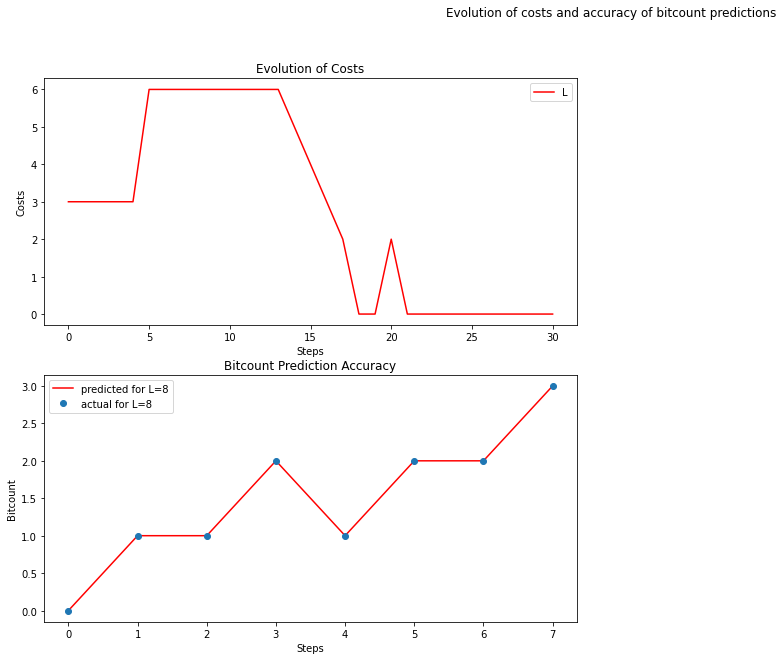

In [8]:
    def see_annealing(costs, L_time, L_count):
        plt.figure()
        plt.suptitle("Evolution of costs and accuracy of bitcount predictions")
        plt.subplot(221)
        plt.plot(costs, 'r')
        plt.xlabel('Steps')
        plt.ylabel('Costs')
        plt.title("Evolution of Costs")
        plt.legend(('L=8 at T=800'), loc='upper right')

        plt.subplot(223)
        plt.plot(pred_bit, 'r', target, 'o')
        plt.xlabel('Steps')
        plt.ylabel('Bitcount')
        plt.title("Bitcount Prediction Accuracy")
        plt.legend(('predicted for L=8','actual for L=8'), loc='upper left')
        plt.show()

    see_annealing(costs, L_time, L_count)  

In [9]:
    qc = qc_list[i] + qc_had + qc_ent + qc_rot + qc_out
    qc.draw()

┌───┐┌─┐┌───┐                                                       »
q_0: ┤ X ├┤M├┤ H ├───────■───────────────────────────────────────────────»
     ├───┤└╥┘└┬─┬┘┌───┐┌─┴─┐                                             »
q_1: ┤ X ├─╫──┤M├─┤ H ├┤ X ├──■──────────────────────────────────────────»
     ├───┤ ║  └╥┘ └┬─┬┘├───┤┌─┴─┐                                        »
q_2: ┤ X ├─╫───╫───┤M├─┤ H ├┤ X ├──■─────────────────────────────────────»
     ├───┤ ║   ║   └╥┘ └───┘└───┘┌─┴─┐     ┌─────────────┐┌─────────────┐»
q_3: ┤ H ├─╫───╫────╫────────────┤ X ├──■──┤ RY(0.57624) ├┤ RZ(0.57624) ├»
     ├───┤ ║   ║    ║            └───┘┌─┴─┐└─────────────┘├─────────────┤»
q_4: ┤ H ├─╫───╫────╫─────────────────┤ X ├───────■───────┤ RY(0.57624) ├»
     ├───┤ ║   ║    ║                 └───┘     ┌─┴─┐     └─────────────┘»
q_5: ┤ H ├─╫───╫────╫───────────────────────────┤ X ├────────────■───────»
     ├───┤ ║   ║    ║                           └───┘          ┌─┴─┐     »
q_6: ┤ H ├─╫───╫────╫──────────────────────────────────────────┤ X ├─────»
     ├───┤ ║   ║    ║                                          └───┘     »
q_7: ┤ H ├─╫───╫────╫────────────────────────────────────────────────────»
     └───┘ ║   ║    ║                                                    »
c: 8/══════╩═══╩════╩════════════════════════════════════════════════════»
           0   1    2                                                    »
«                    ┌───┐                                             »
«q_0: ───────────────┤ X ├─────────────────────────────────────────────»
«                    └─┬─┘                                             »
«q_1: ─────────────────┼───────────────────────────────────────────────»
«                      │                                               »
«q_2: ─────────────────┼───────────────────────────────────────────────»
«     ┌─────────────┐  │  ┌─────────────┐┌─────────────┐┌─────────────┐»
«q_3: ┤ RY(0.47405) ├──┼──┤ RZ(0.47405) ├┤ RY(0.41646) ├┤ RZ(0.41646) ├»
«     ├─────────────┤  │  ├─────────────┤├─────────────┤├─────────────┤»
«q_4: ┤ RZ(0.57624) ├──┼──┤ RY(0.47405) ├┤ RZ(0.47405) ├┤ RY(0.41646) ├»
«     ├─────────────┤  │  ├─────────────┤├─────────────┤├─────────────┤»
«q_5: ┤ RY(0.57624) ├──┼──┤ RZ(0.57624) ├┤ RY(0.47405) ├┤ RZ(0.47405) ├»
«     └─────────────┘  │  ├─────────────┤├─────────────┤├─────────────┤»
«q_6: ───────■─────────┼──┤ RY(0.57624) ├┤ RZ(0.57624) ├┤ RY(0.47405) ├»
«          ┌─┴─┐       │  ├─────────────┤├─────────────┤├─────────────┤»
«q_7: ─────┤ X ├───────■──┤ RY(0.57624) ├┤ RZ(0.57624) ├┤ RY(0.47405) ├»
«          └───┘          └─────────────┘└─────────────┘└─────────────┘»
«c: 8/═════════════════════════════════════════════════════════════════»
«                                                                      »
«                                                                     »
«q_0: ────────────────────────────────────────────────────────────────»
«                                                                     »
«q_1: ────────────────────────────────────────────────────────────────»
«                                                                     »
«q_2: ────────────────────────────────────────────────────────────────»
«     ┌──────────────┐┌──────────────┐┌─────────────┐ ┌─────────────┐ »
«q_3: ┤ RY(-0.79241) ├┤ RZ(-0.79241) ├┤ RY(-1.2489) ├─┤ RZ(-1.2489) ├─»
«     ├─────────────┬┘├──────────────┤├─────────────┴┐├─────────────┤ »
«q_4: ┤ RZ(0.41646) ├─┤ RY(-0.79241) ├┤ RZ(-0.79241) ├┤ RY(-1.2489) ├─»
«     ├─────────────┤ ├─────────────┬┘├──────────────┤├─────────────┴┐»
«q_5: ┤ RY(0.41646) ├─┤ RZ(0.41646) ├─┤ RY(-0.79241) ├┤ RZ(-0.79241) ├»
«     ├─────────────┤ ├─────────────┤ ├─────────────┬┘├──────────────┤»
«q_6: ┤ RZ(0.47405) ├─┤ RY(0.41646) ├─┤ RZ(0.41646) ├─┤ RY(-0.79241) ├»
«     ├─────────────┤ ├─────────────┤ ├─────────────┤ ├──────────────┤»
«q_7: ┤ RZ(0.47405) ├─┤ RY(0.41646) ├─┤ RZ(0.41646) ├─┤ RY(-0.79241) ├»
«     └─────────────┘ └─────────────┘ └──

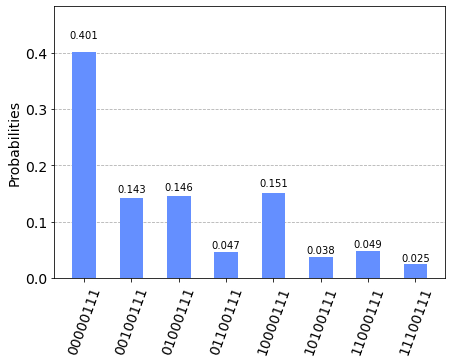

In [10]:
    counts = execute(qc, dev).result().get_counts()
    plot_histogram(counts)

In [11]:
    provider = IBMQ.enable_account('8d998fdc9c89795f3b35f8fc6ca5ee0d1725be7fde1a17fb4e519b11e07f7f84a94df7e8ed64569874a8e0f0220aff9bbb5b78daadeb9aa288628e739be58a63')
    backend = provider.backends.ibmq_16_melbourne

    qobj = assemble(transpile(qc, backend=backend), backend=backend) 
    job = backend.run(qobj) 

    print(job.result().get_counts())

C:\Users\1147035\AppData\Local\Continuum\anaconda3\envs\MLQ\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:109: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


IBMQJobFailureError: 'Unable to retrieve result for job 5fd956ed5fb7c10019f32ff9. Job has failed: Qubit measurement not the final instruction.. Error code: 7006.'